In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, classification_report
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler


import warnings            
warnings.filterwarnings("ignore")

In [2]:
dados = pd.read_csv("datasets/dataset_churn.csv")
dados["Renda Mensal Presumida (R$)"] = dados["Renda Mensal Presumida (R$)"].round(2)
dados.head()

,Score Crédito,Estado,Gênero,Idade,Tempo como cliente (meses),Saldo,Número de produtos,Possui Cartao de Crédito,Assina mensalidade,Renda Mensal Presumida (R$),Churn_2_meses
0,619,São Paulo,Feminino,42,2,0.00,1,1,1,4222.87,1
1,608,Rio de Janeiro,Feminino,41,1,83807.86,1,0,1,4689.27,0
2,502,São Paulo,Feminino,42,8,159660.80,3,1,0,4747.15,1
3,699,São Paulo,Feminino,39,1,0.00,2,0,0,3909.44,0
4,850,Rio de Janeiro,Feminino,43,2,125510.82,1,1,1,3295.17,0


## 1 - EDA

In [3]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
Score Crédito                  10000 non-null int64
Estado                         10000 non-null object
Gênero                         10000 non-null object
Idade                          10000 non-null int64
Tempo como cliente (meses)     10000 non-null int64
Saldo                          10000 non-null float64
Número de produtos             10000 non-null int64
Possui Cartao de Crédito       10000 non-null int64
Assina mensalidade             10000 non-null int64
Renda Mensal Presumida (R$)    10000 non-null float64
Churn_2_meses                  10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 781.3+ KB


In [4]:
faltantes = dados.isnull().sum()
faltantes_percentual = (dados.isnull().sum()) / len(dados["Churn_2_meses"]) * 100
print(f"Tabela faltantes_percentual: \n{faltantes_percentual}\n")

Tabela faltantes_percentual: 
Score Crédito                  0.0
Estado                         0.0
Gênero                         0.0
Idade                          0.0
Tempo como cliente (meses)     0.0
Saldo                          0.0
Número de produtos             0.0
Possui Cartao de Crédito       0.0
Assina mensalidade             0.0
Renda Mensal Presumida (R$)    0.0
Churn_2_meses                  0.0
dtype: float64



 - Não existem dados faltantes no conjunto de dados analisado. 

In [5]:
pd.DataFrame(dados.groupby(["Churn_2_meses"]).mean().round(2))

,Score Crédito,Idade,Tempo como cliente (meses),Saldo,Número de produtos,Possui Cartao de Crédito,Assina mensalidade,Renda Mensal Presumida (R$)
Churn_2_meses,,,,,,,,
0,651.85,37.41,5.03,72745.30,1.54,0.71,0.55,4155.77
1,645.35,44.84,4.93,91108.54,1.48,0.70,0.36,4227.74


- Observando o dataframe acima podemos observar que algumas variáveis não apresentam média distinta em relação à realizar o churn ou não.

In [6]:
dados["Churn_2_meses"].value_counts(normalize =True)

0    0.7963
1    0.2037
Name: Churn_2_meses, dtype: float64

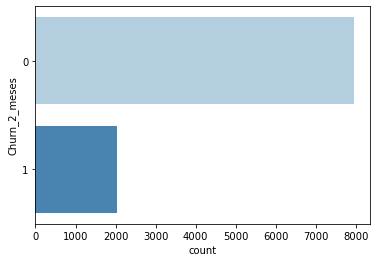

In [7]:
ax = sns.countplot(data = dados, y = "Churn_2_meses", palette = "Blues")

- A variável target está desbalanceada. 

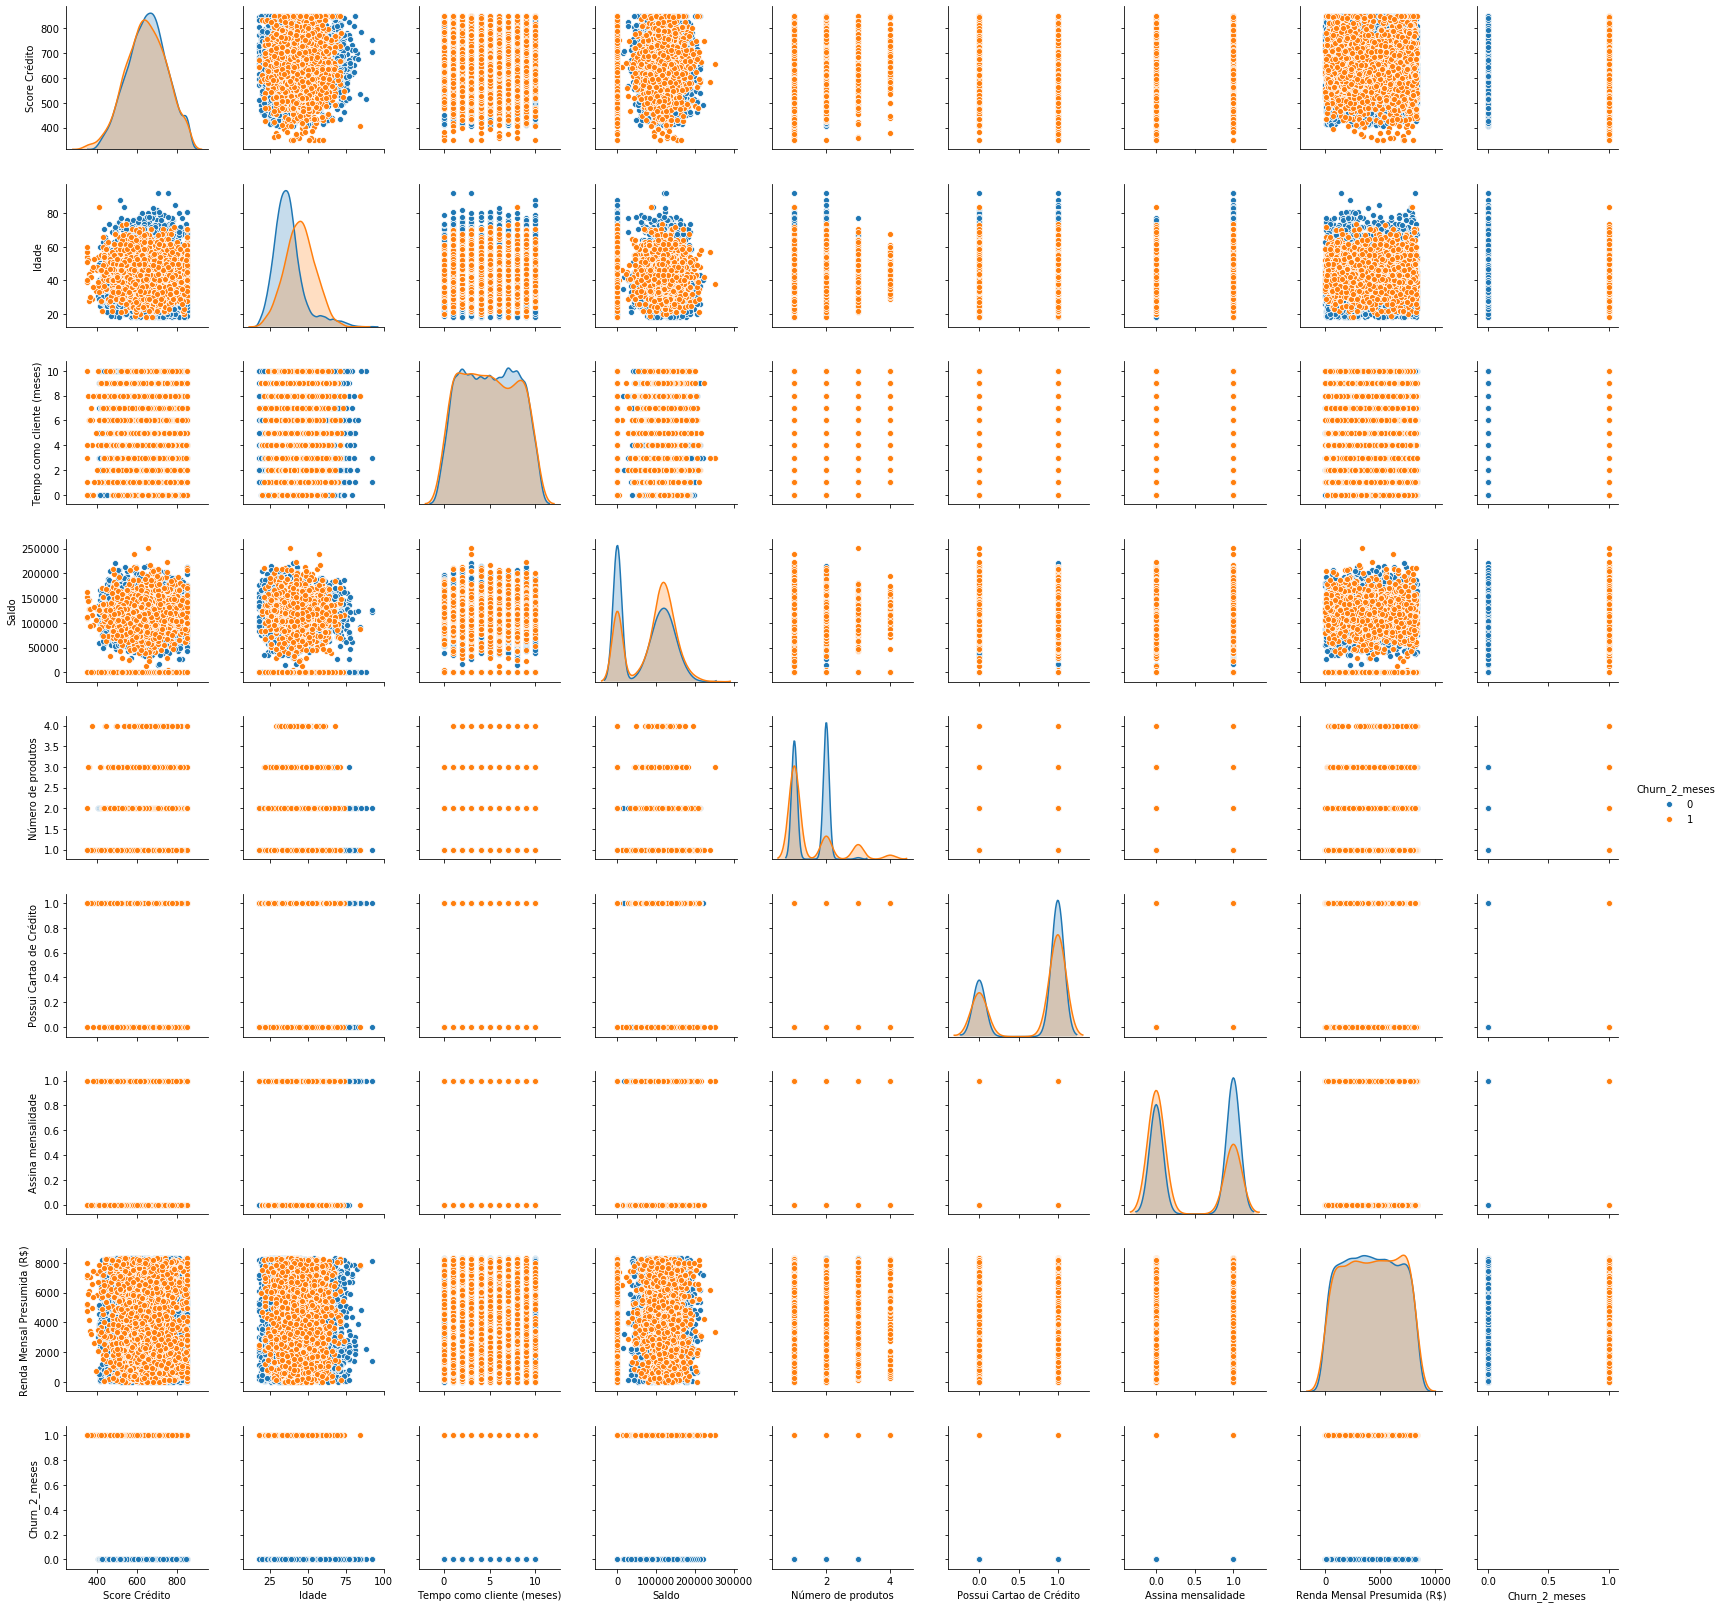

In [8]:
sns.pairplot(data = dados, hue = "Churn_2_meses")

In [8]:
def dist_plot_feature(feature):
    plt.figure(figsize=(14,8))
    sns.distplot(dados.loc[dados["Churn_2_meses"]==1, feature], label='churn_true')
    sns.distplot(dados.loc[dados["Churn_2_meses"]==0, feature], label='churn_false')
    plt.legend()
    ax

def box_plot_feature(feature, ylabel):
    ax = sns.boxplot(y = feature, x = "Churn_2_meses", data = dados, orient = "v", width = 0.2, palette = "viridis")
    ax.figure.set_size_inches(12,6)
    ax.set_title("Boxplot", fontsize = 20)
    ax.set_ylabel(ylabel, fontsize = 16)
    ax.set_xlabel('Churn após 2 meses', fontsize = 16)
    ax

#### Idade

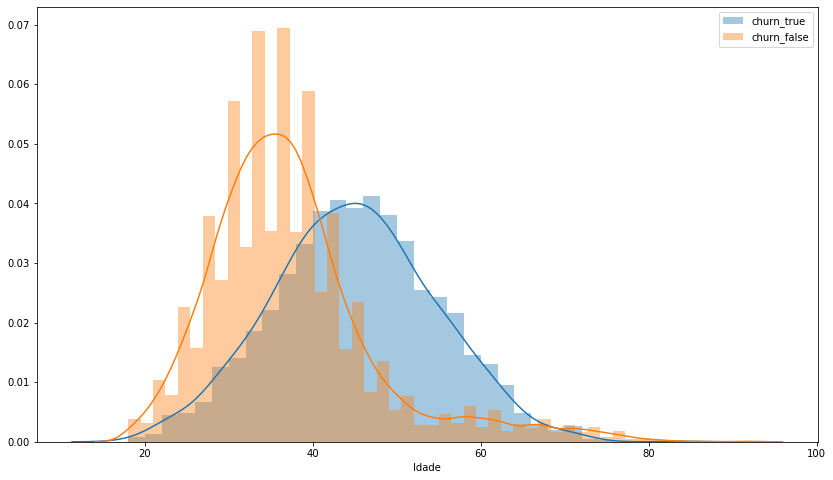

In [9]:
dist_plot_feature("Idade")

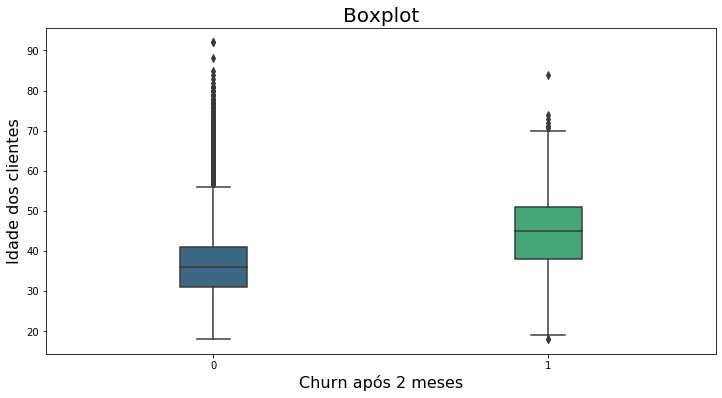

In [10]:
box_plot_feature("Idade", "Idade dos clientes")

- A **variável idade** aparenta ser uma variável importante para o modelo, visto que a média da idade de pessoas que realizararam o churn é maior do que a dos individuos que não realizaram o churn.
- O gráfico do boxplot demonstra a presença de **outliers**.

#### Saldo

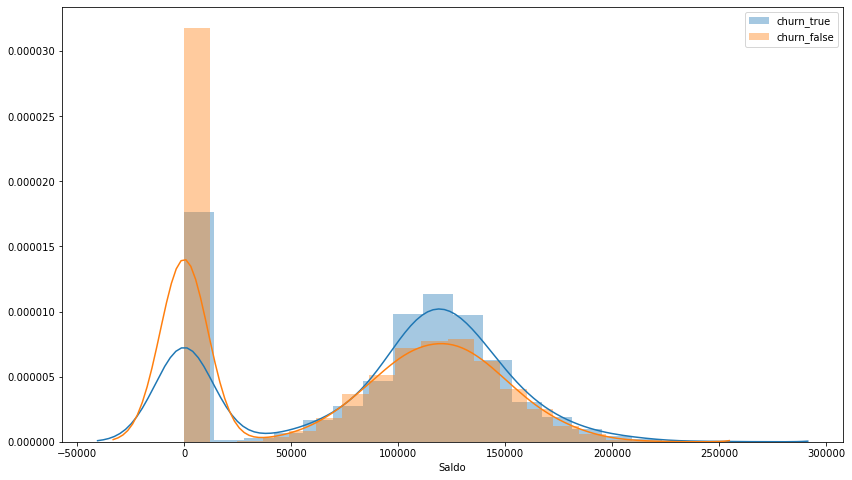

In [11]:
dist_plot_feature("Saldo")

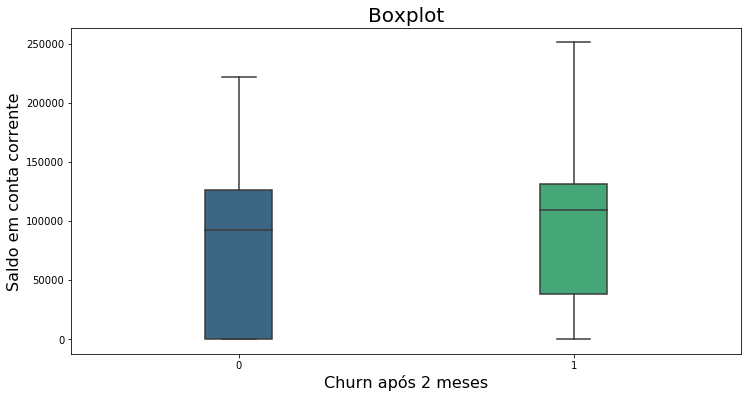

In [12]:
box_plot_feature("Saldo", "Saldo em conta corrente")

- Pessoas com saldo maior tem maior probabilidade de realizar o churn.

#### Renda

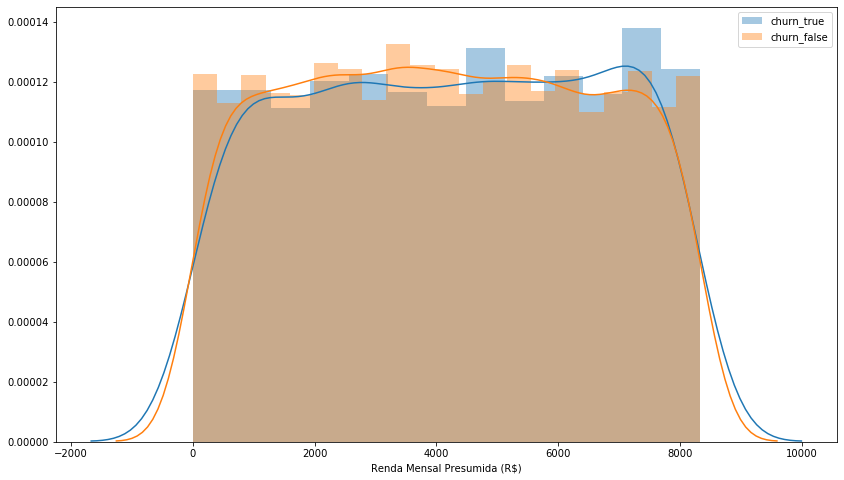

In [13]:
dist_plot_feature("Renda Mensal Presumida (R$)")

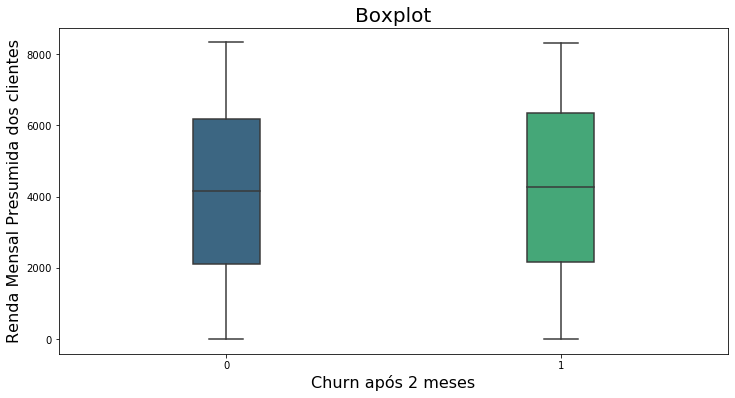

In [14]:
box_plot_feature("Renda Mensal Presumida (R$)", "Renda Mensal Presumida dos clientes")

- A variável Renda não aparenta ser uma variável decisiva no conjunto de dados analisados.

### Tratando variáveis categóricas 

In [15]:
dados = pd.get_dummies(dados, columns = ['Gênero'], drop_first = True)
dados.head()

,Score Crédito,Estado,Idade,Tempo como cliente (meses),Saldo,Número de produtos,Possui Cartao de Crédito,Assina mensalidade,Renda Mensal Presumida (R$),Churn_2_meses,Gênero_Masculino
0,619,São Paulo,42,2,0.00,1,1,1,4222.87,1,0
1,608,Rio de Janeiro,41,1,83807.86,1,0,1,4689.27,0,0
2,502,São Paulo,42,8,159660.80,3,1,0,4747.15,1,0
3,699,São Paulo,39,1,0.00,2,0,0,3909.44,0,0
4,850,Rio de Janeiro,43,2,125510.82,1,1,1,3295.17,0,0


In [16]:
pd.crosstab(dados["Churn_2_meses"], dados["Gênero_Masculino"], normalize = "columns").round(2)*100

Gênero_Masculino,0,1
Churn_2_meses,,
0,75.0,84.0
1,25.0,16.0


- As mulheres apresentam um maior percentual de realização do churn em relação aos homens.

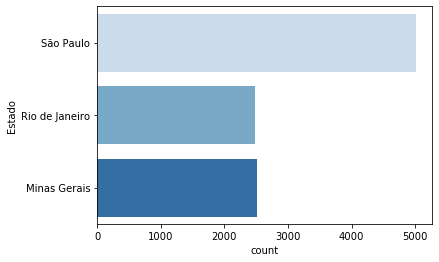

In [17]:
sns.countplot(data = dados, y = "Estado", palette = "Blues")

In [18]:
pd.crosstab(dados["Churn_2_meses"], dados["Estado"], normalize = "columns").round(2)*100

Estado,Minas Gerais,Rio de Janeiro,São Paulo
Churn_2_meses,,,
0,68.0,83.0,84.0
1,32.0,17.0,16.0


- Entre os 3 estados, Minas gerais é o estado que apresenta o maior valor percentual de churn, quase o dobro de SP e RJ.

In [19]:
dados = pd.get_dummies(dados, columns=["Estado"])
dados.head()

,Score Crédito,Idade,Tempo como cliente (meses),Saldo,Número de produtos,Possui Cartao de Crédito,Assina mensalidade,Renda Mensal Presumida (R$),Churn_2_meses,Gênero_Masculino,Estado_Minas Gerais,Estado_Rio de Janeiro,Estado_São Paulo
0,619,42,2,0.00,1,1,1,4222.87,1,0,0,0,1
1,608,41,1,83807.86,1,0,1,4689.27,0,0,0,1,0
2,502,42,8,159660.80,3,1,0,4747.15,1,0,0,0,1
3,699,39,1,0.00,2,0,0,3909.44,0,0,0,0,1
4,850,43,2,125510.82,1,1,1,3295.17,0,0,0,1,0


### Estatística Descritivas 

In [20]:
dados.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Score Crédito,10000.0,650.53,96.65,350.00,584.00,652.00,718.00,850.00
Idade,10000.0,38.92,10.49,18.00,32.00,37.00,44.00,92.00
Tempo como cliente (meses),10000.0,5.01,2.89,0.00,3.00,5.00,7.00,10.00
Saldo,10000.0,76485.89,62397.41,0.00,0.00,97198.54,127644.24,250898.09
Número de produtos,10000.0,1.53,0.58,1.00,1.00,1.00,2.00,4.00
Possui Cartao de Crédito,10000.0,0.71,0.46,0.00,0.00,1.00,1.00,1.00
Assina mensalidade,10000.0,0.52,0.50,0.00,0.00,1.00,1.00,1.00
Renda Mensal Presumida (R$),10000.0,4170.43,2396.27,0.48,2125.09,4174.75,6224.51,8333.02
Churn_2_meses,10000.0,0.20,0.40,0.00,0.00,0.00,0.00,1.00
Gênero_Masculino,10000.0,0.55,0.50,0.00,0.00,1.00,1.00,1.00


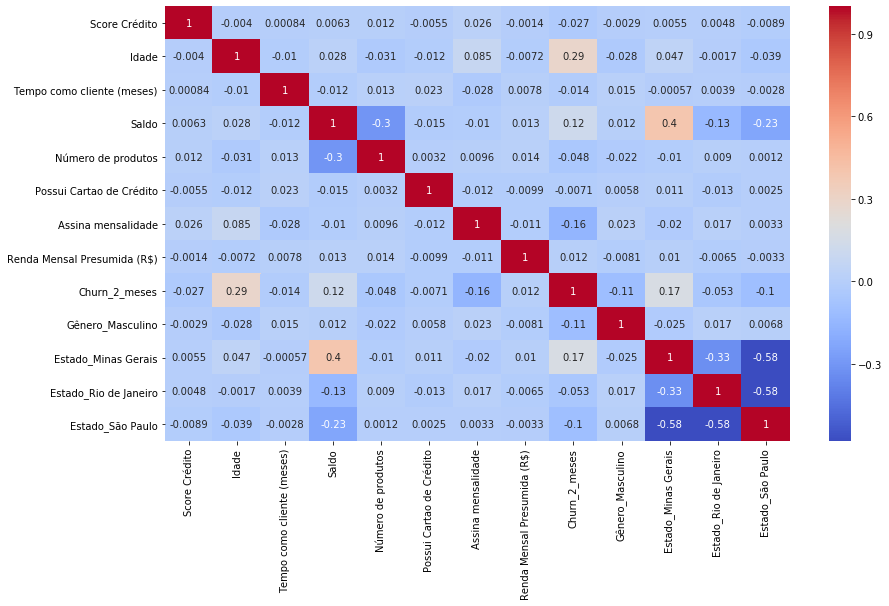

In [21]:
plt.figure(figsize=(14,8))
sns.heatmap(dados.corr(), annot=True, cmap='coolwarm')

- Observando o mapa de correlações, as variáveis **Idade**, **Saldo** e **Estado_Minas_Gerais** apresentam as maiores correlações positivas.
- Já as variáveis **Assina mensalidade** e **Gênero_Masculino** geram um efeito negativo na variável target, ou seja, caso o individuo assine a mensalidade, maior a probabildade dele não realizar o churn.

## Removendo Outliers

In [23]:
def remove_outliers(features, data):
    for x in features:
        Q1 = data[x].quantile(q = 0.25)
        Q3 = data[x].quantile(q = 0.75)
        IQR = Q3 - Q1
        inf = Q1 - 1.5 * IQR
        sup = Q3 + 1.5 * IQR
        df = data[(data[x] > inf) & (data[x] < sup)]
        return df

In [51]:
features = ["Idade"]
for x in features:
        Q1 = dados[x].quantile(q = 0.25)
        Q3 = dados[x].quantile(q = 0.75)
        IQR = Q3 - Q1
        inf = Q1 - 1.5 * IQR
        sup = Q3 + 1.5 * IQR
        dados = dados[(dados[x] > inf) & (dados[x] < sup)]
dados.shape

(9589, 13)

## Separando as variáveis

In [81]:
y = dados[["Churn_2_meses"]]
X = dados.drop("Churn_2_meses", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [82]:
def get_metrics(modelo, x, y, cmap):    
    y_pred = modelo.predict(x)
    print(f"========> Modelo - {modelo.__class__.__name__}\n")
    print(classification_report(y_test, y_pred))
    fig, ax =plt.subplots(1,2, figsize=(12,5))
    plot_roc_curve(modelo, x, y, ax = ax[0])
    plot_confusion_matrix(modelo, x, y, cmap = cmap, ax = ax[1])
    fig.show()

##  Modelo Base

In [83]:
clf_ds = DummyClassifier(strategy = "most_frequent")
clf_ds.fit(X_train, y_train)
acuracia = clf_ds.score(X_test, y_test) * 100

print("A acurácia do dummy stratified foi %.2f%%" % acuracia)

A acurácia do dummy stratified foi 79.63%


========> Modelo - DummyClassifier

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      2389
           1       0.00      0.00      0.00       611

    accuracy                           0.80      3000
   macro avg       0.40      0.50      0.44      3000
weighted avg       0.63      0.80      0.71      3000



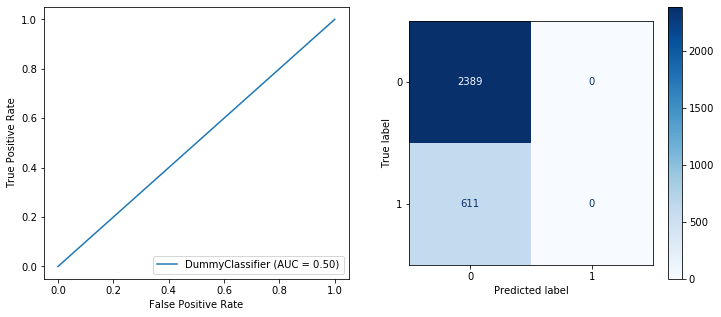

In [84]:
get_metrics(clf_ds, X_test, y_test, "Blues")

## Modelo - Regressão Logística

In [85]:
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
acuracia = clf_lr.score(X_test, y_test) * 100

print("A acurácia do clf_lr foi %.2f%%" % acuracia)

A acurácia do clf_lr foi 79.47%


========> Modelo - LogisticRegression

              precision    recall  f1-score   support

           0       0.80      0.98      0.88      2389
           1       0.46      0.05      0.09       611

    accuracy                           0.79      3000
   macro avg       0.63      0.52      0.49      3000
weighted avg       0.73      0.79      0.72      3000



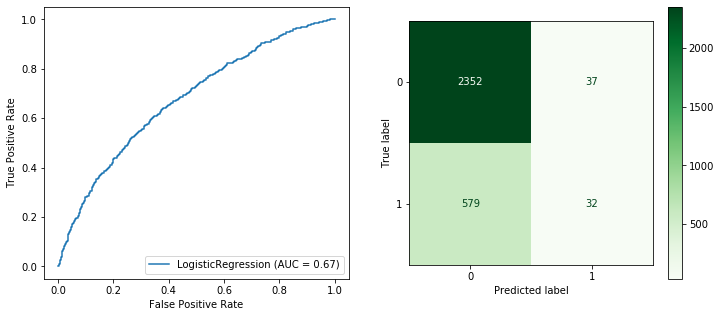

In [86]:
get_metrics(clf_lr, X_test, y_test, "Greens")

### Ajuste fino dos parâmetros Regressão Logística

In [87]:
skf = StratifiedKFold(10, shuffle = True, random_state = 42)
grid_values = {"solver": ['newton-cg', 'lbfgs', 'liblinear'], "C": np.array([0.1, 0.5, 1, 5, 10]), "penalty":["l1","l2", "inelastic"]}

clf_lr = LogisticRegression()
grid_lr = GridSearchCV(clf_lr, param_grid = grid_values, cv = skf)
grid_lr.fit(X_train, y_train)

print("Melhor solver:", grid_lr.best_estimator_.solver)
print("Melhor acurácia:", grid_lr.best_score_.round(2)*100)
print("Melhor C:", grid_lr.best_estimator_.C)
print("Método penalidade:", grid_lr.best_estimator_.penalty)

Melhor solver: liblinear
Melhor acurácia: 81.08999999999999
Melhor C: 1.0
Método penalidade: l1


In [88]:
clf_lr_best = LogisticRegression(solver = "liblinear", C = 1, penalty = "l1")
clf_lr_best.fit(X_train, y_train)
acuracia = clf_lr_best.score(X_test, y_test) * 100
print("A acurácia do clf_lr_best foi %.2f%%" % acuracia)

A acurácia do clf_lr_best foi 81.27%


========> Modelo - LogisticRegression

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      2389
           1       0.63      0.19      0.30       611

    accuracy                           0.81      3000
   macro avg       0.73      0.58      0.59      3000
weighted avg       0.79      0.81      0.77      3000



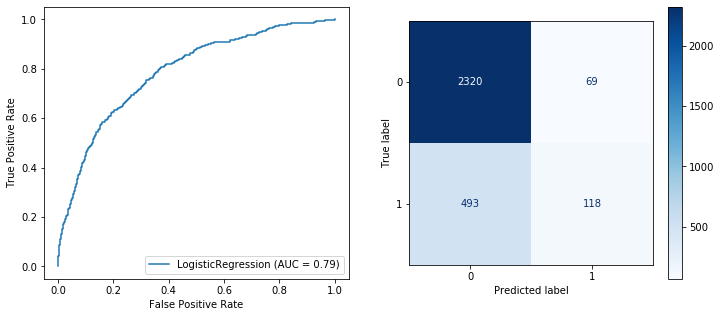

In [89]:
get_metrics(clf_lr_best, X_test, y_test, "Blues")

## Modelo KNN

In [92]:
normalizador = MinMaxScaler(feature_range=(0, 1))
X_norm = normalizador.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size = 0.3, random_state = 42, stratify = y)

clf_knn = KNeighborsClassifier(n_neighbors = 5)
clf_knn.fit(X_train, y_train)
acuracia = clf_knn.score(X_test, y_test) * 100
print("A acurácia do clf_knn foi %.2f%%" % acuracia)

A acurácia do clf_knn foi 81.67%


========> Modelo - KNeighborsClassifier

              precision    recall  f1-score   support

           0       0.85      0.94      0.89      2389
           1       0.59      0.32      0.42       611

    accuracy                           0.82      3000
   macro avg       0.72      0.63      0.65      3000
weighted avg       0.79      0.82      0.79      3000



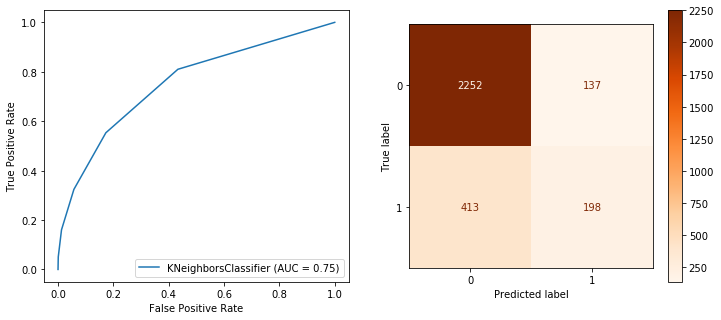

In [93]:
get_metrics(clf_knn, X_test, y_test, "Oranges")

### Ajuste fino dos parâmetros KNN

In [94]:
skf = StratifiedKFold(10, shuffle = True, random_state = 42)
grid_values = {"n_neighbors": np.array([3, 5, 7, 9, 11, 13]),
               "metric": ["chebyshev", "minkowski", "manhattan"],
               "p": np.array([1, 2, 3, 4])}

clf_knn = KNeighborsClassifier()
grid_knn = GridSearchCV(clf_knn, param_grid = grid_values, cv = skf)
grid_knn.fit(X_train, y_train)

print("Melhor acurácia:", grid_knn.best_score_.round(2)*100)
print("Melhor K:", grid_knn.best_estimator_.n_neighbors)
print("Método distância:", grid_knn.best_estimator_.metric)
print("Melhor valor p:", grid_knn.best_estimator_.p)

Melhor acurácia: 82.0
Melhor K: 11
Método distância: minkowski
Melhor valor p: 1


In [95]:
clf_knn_best = KNeighborsClassifier(n_neighbors = 11, metric = "minkowski", p = 1 )
clf_knn_best.fit(X_train, y_train)
acuracia = clf_knn_best.score(X_test, y_test) * 100
print("A acurácia do clf_knn_best foi %.2f%%" % acuracia)

A acurácia do clf_knn_best foi 82.27%


========> Modelo - KNeighborsClassifier

              precision    recall  f1-score   support

           0       0.83      0.97      0.90      2389
           1       0.68      0.25      0.36       611

    accuracy                           0.82      3000
   macro avg       0.76      0.61      0.63      3000
weighted avg       0.80      0.82      0.79      3000



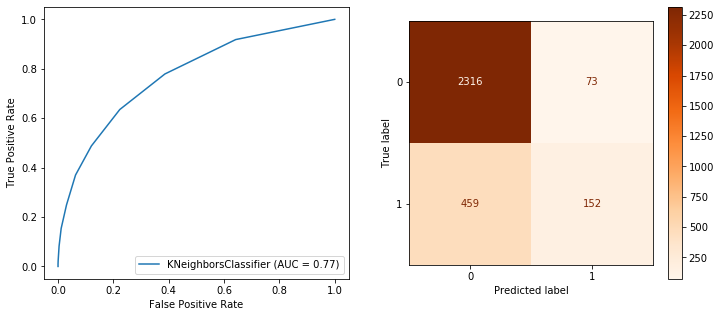

In [96]:
get_metrics(clf_knn_best, X_test, y_test, "Oranges")

## DecisionTreeClassifier

In [124]:
y = dados[["Churn_2_meses"]]
X = dados.drop("Churn_2_meses", axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [125]:
clf_dt = DecisionTreeClassifier(random_state = 42)
clf_dt.fit(X_train, y_train)
acuracia = clf_dt.score(X_test, y_test) * 100
print("A acurácia do clf_dt foi %.2f%%" % acuracia)

A acurácia do clf_dt foi 79.07%


========> Modelo - DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2389
           1       0.49      0.50      0.49       611

    accuracy                           0.79      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.79      0.79      0.79      3000



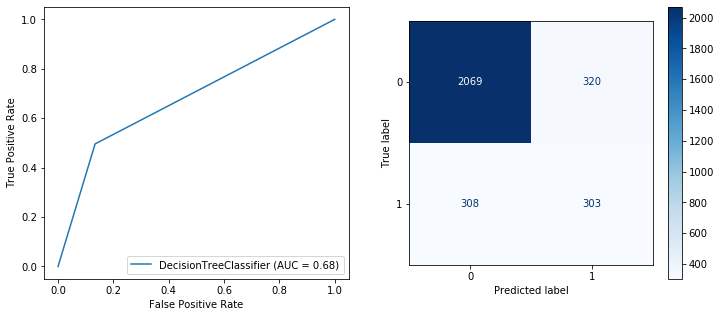

In [126]:
get_metrics(clf_dt, X_test, y_test, "Blues")

### Ajuste fino dos parâmetros DecisionTreeClassifier

In [128]:
skf = StratifiedKFold(10, shuffle = True, random_state = 42)
grid_values = {"max_depth": np.arange(1, 20),
               "min_samples_split": np.array([2, 3, 4, 6, 8, 10]),
               "min_samples_leaf": np.array([1, 2, 3, 4])}

clf_dt = DecisionTreeClassifier()
grid_dt = GridSearchCV(clf_dt, param_grid = grid_values, cv = skf)
grid_dt.fit(X_train, y_train)

print("Melhor acurácia:", grid_dt.best_score_.round(2)*100)
print("max_depth:", grid_dt.best_estimator_.max_depth)
print("min_samples_split:", grid_dt.best_estimator_.min_samples_split)
print("min_samples_leaf:", grid_dt.best_estimator_.min_samples_leaf)

Melhor acurácia: 86.0
max_depth: 6
min_samples_split: 6
min_samples_leaf: 3


In [129]:
clf_dt_best = DecisionTreeClassifier(max_depth = 6, min_samples_split = 6,
                                     min_samples_leaf = 3, random_state = 42 )
clf_dt_best.fit(X_train, y_train)
acuracia = clf_dt_best.score(X_test, y_test) * 100
print("A acurácia do clf_dt_best foi %.2f%%" % acuracia)

A acurácia do clf_dt_best foi 86.30%


========> Modelo - DecisionTreeClassifier

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2389
           1       0.77      0.47      0.58       611

    accuracy                           0.86      3000
   macro avg       0.82      0.72      0.75      3000
weighted avg       0.85      0.86      0.85      3000



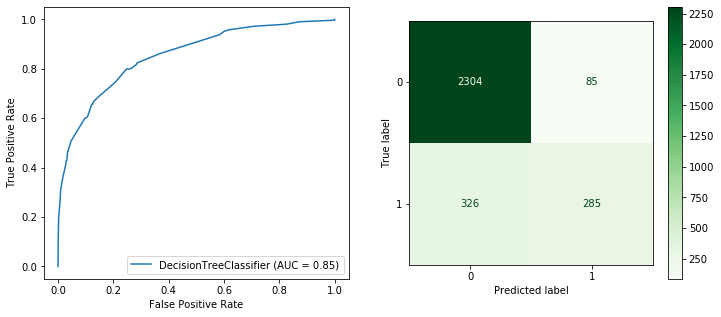

In [130]:
get_metrics(clf_dt_best, X_test, y_test, "Greens")

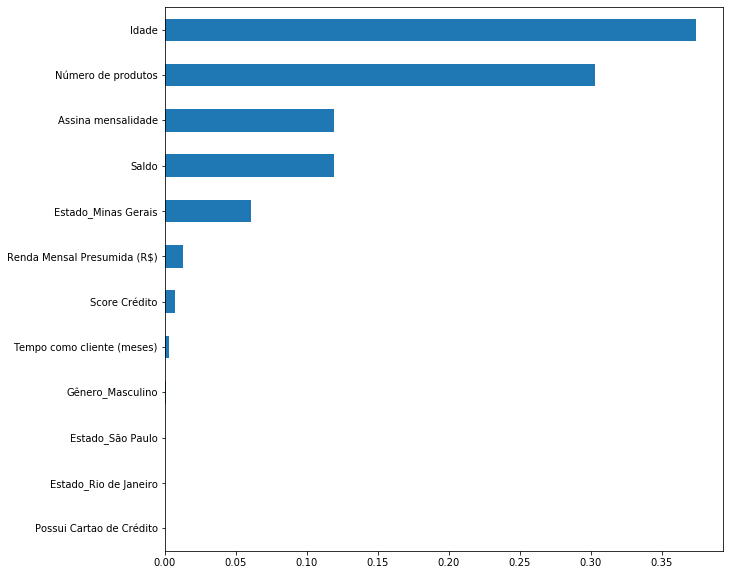

In [123]:
feat = pd.Series(clf_dt_best.feature_importances_, index = X_train.columns)
feat.sort_values().plot(figsize = (10, 10), kind = 'barh');

- O ajustamento dos parâmetros melhorou significativamente a performance do modelo de Árvore de Decisão.
- As varíaveis como maior peso no modelo são **idade**, **número de produtos** e **assina mensalidade**.

## Random Forest Classifier

In [133]:
clf_rf = RandomForestClassifier(random_state = 42)
clf_rf.fit(X_train, y_train)
acuracia = clf_rf.score(X_test, y_test) * 100
print("A acurácia do clf_rf foi %.2f%%" % acuracia)

A acurácia do clf_rf foi 86.37%


========> Modelo - RandomForestClassifier

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2389
           1       0.77      0.47      0.59       611

    accuracy                           0.86      3000
   macro avg       0.82      0.72      0.75      3000
weighted avg       0.86      0.86      0.85      3000



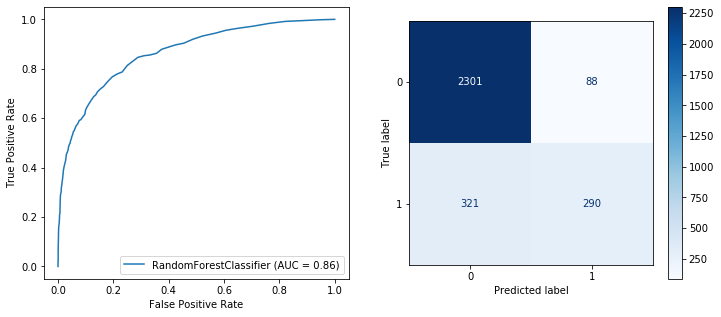

In [134]:
get_metrics(clf_rf, X_test, y_test, "Blues")

In [135]:
skf = StratifiedKFold(10, shuffle = True, random_state = 42)
grid_values = {"max_depth": np.arange(1, 20),
               "min_samples_split": np.array([2, 4, 6, 8, 10, 12]),
               "min_samples_leaf": np.array([1, 2, 3, 4])}

clf_rf = RandomForestClassifier(random_state = 42)
grid_rf = GridSearchCV(clf_dt, param_grid = grid_values, cv = skf)
grid_rf.fit(X_train, y_train)

print("Melhor acurácia:", grid_rf.best_score_.round(2)*100)
print("max_depth:", grid_rf.best_estimator_.max_depth)
print("min_samples_split:", grid_rf.best_estimator_.min_samples_split)
print("min_samples_leaf:", grid_rf.best_estimator_.min_samples_leaf)

Melhor acurácia: 86.0
max_depth: 6
min_samples_split: 12
min_samples_leaf: 3


In [136]:
clf_rf_best = RandomForestClassifier(max_depth = 6, min_samples_split = 12, min_samples_leaf = 3, random_state = 42)
clf_rf_best.fit(X_train, y_train)
acuracia = clf_rf_best.score(X_test, y_test) * 100
print("A acurácia do clf_rf_best foi %.2f%%" % acuracia)

A acurácia do clf_rf_best foi 86.07%


========> Modelo - RandomForestClassifier

              precision    recall  f1-score   support

           0       0.86      0.98      0.92      2389
           1       0.86      0.38      0.53       611

    accuracy                           0.86      3000
   macro avg       0.86      0.68      0.72      3000
weighted avg       0.86      0.86      0.84      3000



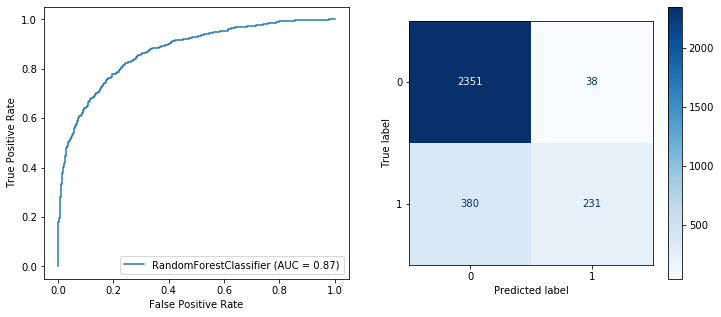

In [137]:
get_metrics(clf_rf_best, X_test, y_test, "Blues")

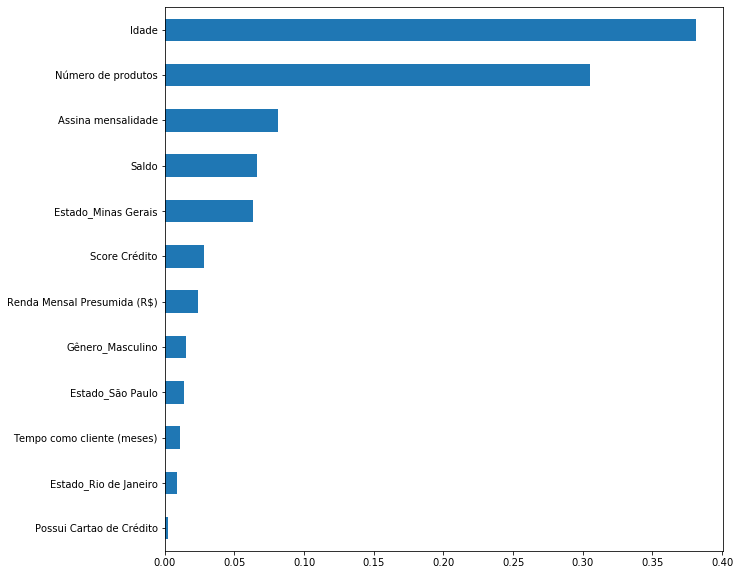

In [184]:
feat = pd.Series(clf_rf_best.feature_importances_, index = X_train.columns)
feat.sort_values().plot(figsize = (10, 10), kind = 'barh');

In [ ]:
- O ajustamento dos hiperparâmetros não demonstrou uma melhora no modelo acima.

## Modelo GradientBoostingClassifier

In [185]:
clf_gb = GradientBoostingClassifier(random_state = 42)
clf_gb.fit(X_train, y_train)
acuracia =clf_gb.score(X_test, y_test) * 100
print("A acurácia do clf_gb foi %.2f%%" % acuracia)

A acurácia do clf_gb foi 87.30%


========> Modelo - GradientBoostingClassifier

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      2389
           1       0.80      0.50      0.61       611

    accuracy                           0.87      3000
   macro avg       0.84      0.73      0.77      3000
weighted avg       0.87      0.87      0.86      3000



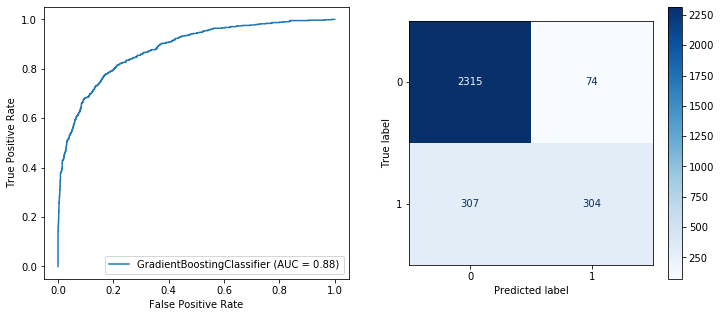

In [186]:
get_metrics(clf_gb, X_test, y_test, "Blues")

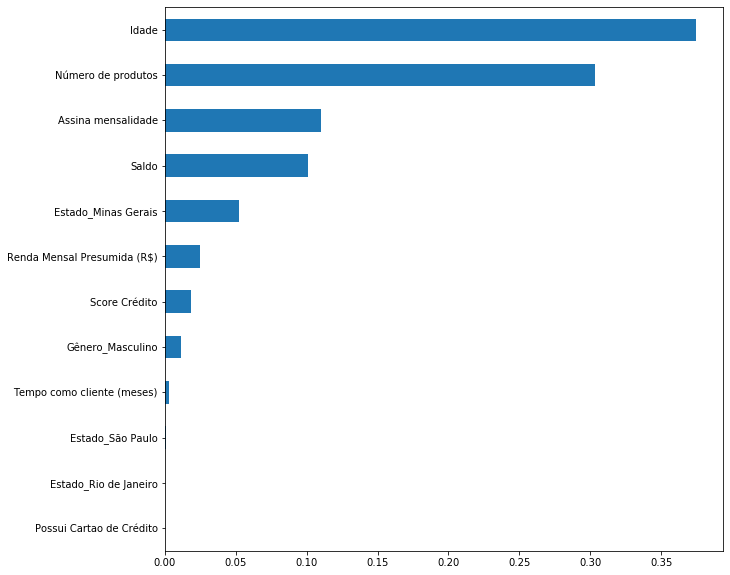

In [187]:
feat = pd.Series(clf_gb.feature_importances_, index = X_train.columns)
feat.sort_values().plot(figsize = (10, 10), kind = 'barh');

In [188]:
skf = StratifiedKFold(5, shuffle = True)
grid_values = {"loss": ["deviance", "exponential"],
               "n_estimators": np.array([100, 125, 150, 200]),
               "min_samples_split": np.array([2, 4, 6, 8, 10, 12])}
              
clf_gb = GradientBoostingClassifier(random_state = 42)
grid_gb = GridSearchCV(clf_gb, param_grid = grid_values, cv = skf)
grid_gb.fit(X_train, y_train)

print("Melhor acurácia:", grid_gb.best_score_.round(2)*100)
print("Loss:", grid_gb.best_estimator_.loss)
print("n_estimators:", grid_gb.best_estimator_.n_estimators)
print("min_samples_leaf:", grid_gb.best_estimator_.min_samples_leaf)

Melhor acurácia: 86.0
Loss: exponential
n_estimators: 200
max_depth: 3
min_samples_split: 6
min_samples_leaf: 1


In [189]:
clf_gb_best = GradientBoostingClassifier(loss = "exponential", n_estimators = 200, min_samples_split = 6, random_state = 42)
clf_gb_best.fit(X_train, y_train)
acuracia = clf_gb_best.score(X_test, y_test) * 100
print("A acurácia do clf_gb foi %.2f%%" % acuracia)

A acurácia do clf_gb foi 86.83%


========> Modelo - GradientBoostingClassifier

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      2389
           1       0.78      0.49      0.60       611

    accuracy                           0.87      3000
   macro avg       0.83      0.73      0.76      3000
weighted avg       0.86      0.87      0.86      3000



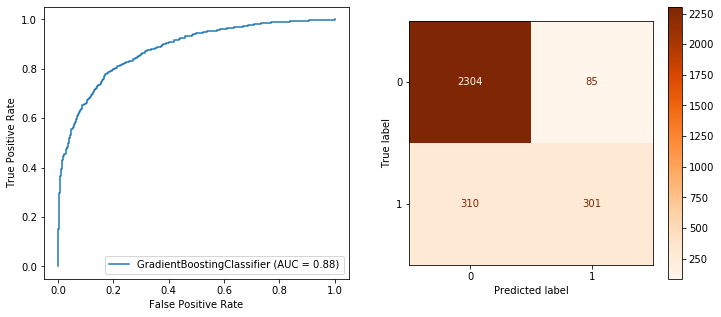

In [190]:
get_metrics(clf_gb_best, X_test, y_test, "Oranges")

## 5 - Comparando modelos e resultados

In [194]:
from tqdm.notebook import tqdm
clfs = [clf_lr_best, clf_knn_best, clf_dt_best, clf_rf_best, clf_gb_best]

In [195]:
lst_f1 = []
lst_clf_name = []

for clf in tqdm(clfs):
    clf_name = clf.__class__.__name__
    print('Treinando no modelo:', clf_name)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    lst_clf_name.append(clf_name)
    lst_f1.append(f1_score(y_test, y_pred))

Treinando no modelo: LogisticRegression
Treinando no modelo: KNeighborsClassifier
Treinando no modelo: DecisionTreeClassifier
Treinando no modelo: RandomForestClassifier
Treinando no modelo: GradientBoostingClassifier



In [196]:
results_f1 = pd.Series(lst_f1, index=lst_clf_name).sort_values()
results_f1

KNeighborsClassifier          0.047619
LogisticRegression            0.301129
RandomForestClassifier        0.525000
DecisionTreeClassifier        0.581040
GradientBoostingClassifier    0.603811
dtype: float64

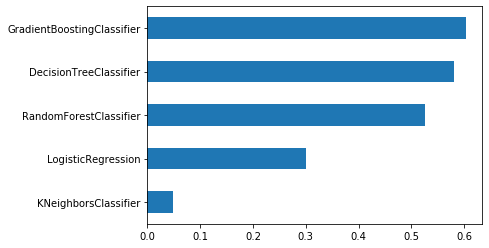

In [197]:
results_f1.plot(kind='barh')

- O melhor modelo analisado que apresentou os melhores resultados foi GradientBoosting Classifier.

- De acordo com o modelo escolhido, as variáveis mais importantes para avaliarmos a realização do churn após 2 meses são:

>**Idade**

>**Número dos Produtos**

>**Assina mensalidade** 